**Machine Learning et classification   **     
**Option Mathématiques appliquées 2019-2020  **    
** Dreem 2 Sleep Stage Classification Challenge  **    
    
Antoine Guiot / Pierre Habin

# **Introduction**    
Dreem est une société française fondée par deux anciens de l’école Polytechnique et d'ISA Supaéro. Cette entreprise, à fort caractère technologique, développe un produit permettant d’améliorer la qualité du sommeil de leurs clients.
En effet, les troubles du sommeil sont de plus en plus présents dans notre société (62% des Français rencontrent au moins un trouble du sommeil). Les méthodes conventionnelles d’analyses du sommeil comme la polysomnographie présentent certains désavantages : elles demandent notamment des équipements très importants et ne peuvent pas être réalisées dans l’environnement de sommeil classique du patient. Elles peuvent donc troubler le sommeil du patient et ainsi fausse les résultats. C’est pour pallier à cela que dreem a conçu un bandeau permettant à lui seul de réaliser cette analyse.

Le bandeau dreem recueille ainsi de nombreuses données électroencéphalographiques qui correspondent à des signaux électriques traduisant l’activité du cerveau. Nous avons à disposition les données recueillies par le dispositif sur plusieurs nuits. L'enjeu de ce projet intervient dans le traitement de ces données.
Effectivement, le bandeau doit dans un premier temps être capable de déterminer dans quelle phase de sommeil se situe le patient pour ensuite agir sur ses différentes phases. Nous allons donc appliquer des techniques de machine Learning et de classification pour relier les données du dispositif à l’une des 5 classes du sommeil.


### Environnement de travail  
Nous avons décidé de travailler sur l'environnement proposé par Kaggle dans le langage python.
Voici les librairies python que nous avons utilisées :

In [1]:
 #This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
from sklearn.ensemble import RandomForestClassifier as RFC #Random Forest
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import f1_score #F1score
import tensorflow as tf 
from sklearn.preprocessing import StandardScaler
from keras.utils import to_categorical
#from entropy import spectral_entropy
import seaborn
from scipy.signal import periodogram, welch
from scipy.stats import kurtosis, skew
from scipy.signal import butter, lfilter

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import h5py #file processing
import matplotlib.pyplot as plt #graphics

Using TensorFlow backend.


/kaggle/input/dreem-sleep-stages-2020/sample_submission.csv
/kaggle/input/dreem-sleep-stages-2020/y_train.csv
/kaggle/input/dreem-sleep-stages-2020/X_test.h5
/kaggle/input/dreem-sleep-stages-2020/X_train.h5


### **Les données**    
On dispose d'une base de données d'entrainement et d'une base de données de test. Ces bases contiennent des enregistrements de 30 secondes des signaux suivants :
* 7 signaux issus des électroencéphalogrammes échantillonnés à 50 Hz
* 3 signaux issus d'accéléromètre pour analyser les mouvements des patients
* 1 signal issu d'un pulsomètre qui permet de déterminer le rythme cardiaque du patient

### Chargement des données   
Nous allons dans un premier temps chargé les données de la base d'entrainement. 

In [2]:
filename = "/kaggle/input/dreem-sleep-stages-2020/X_train.h5"

train_set = h5py.File(filename,'r')
y = pd.read_csv('/kaggle/input/dreem-sleep-stages-2020/y_train.csv')['sleep_stage']

Nous avons alors défini la liste des features de bases correspondant aux données brutes des signaux

In [3]:
input_feature_list = ['eeg_1',
 'eeg_2',
 'eeg_3',
 'eeg_4',
 'eeg_5',
 'eeg_6',
 'eeg_7',
 'x',
 'y',
 'z',
 'pulse']

Voici un exemple de signal brut recueilli par le dispositif

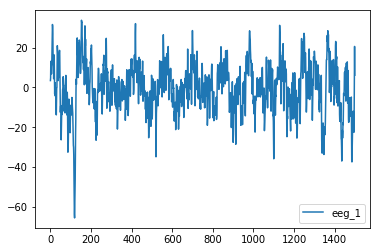

In [4]:
i = 232
index_1 = y[y==4].index.values
plt.plot(train_set['eeg_6'][index_1[i]],label='eeg_1')

plt.legend()

On remarque alors que le signal est très bruité. Nous avons donc décidé d'effectuer une étape de prétraitement des données brutes avant l'application des techniques de machine learning et de classification.

# Prétraitement des données

### Idée
   
Pour réduire le bruit nous avons voulu filtrer les signaux d'entrées avec un filtre passe bande de Butterworth, pour cela nous nous sommes intéréssé aux fréquences caractéristiques des ondes cérébrales associées au sommeil.

### **Fréquence caractéristique du cerveau**   
Les données issues des électroencéphalogrammes présentent une décomposition en plusieurs bandes de fréquences. Certaines de ces bandes de fréquences sont étroitement liées avec le sommeil : 
*  La bande Delta entre 0 et 4 Hz, associée au sommeil profond. 
*  Les ondes Thêta entre 4 et 7,5 Hz, ces ondes apparaissent lorsque le sujet est un état de somnolence.
*  Les ondes Alpha entre 8 et 12 Hz, ces ondes  caractérisent un état de conscience apaisé, et sont principalement émises lorsque le sujet a les yeux fermés.
*  Les ondes Fuseaux, des ondes comprises entre 12 et 16 Hz, caractéristiques de la phase de sommeil léger.   
   
Nous allons donc dimensionner nos filtres de Butterworth dans des zones proches de ces fréquences liées au sommeil.

### **Filtre de Butterworth**   

Nous avons alors construit des fonctions permettant de réaliser des filtres de Butterworth à appliquer à nos données. Voici les fonctions correspondantes 

In [5]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    result=dict()
    new_feature_list = []
    for item in input_feature_list:
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        result[item+'_'+ str(highcut)] = lfilter(b, a, data[item])
        new_feature_list.append(item+'_'+ str(highcut))
    return result

Ces fonctions nous permettent de choisir les bandes passantes que nous souhaitons appliquer aux données. Nous utilisons des filtres d'ordre 5 par défaut.
Nous pouvons donc maintenant appliquer ces filtres à nos données en ciblant les bandes passantes fréquentielles explicités précédemment.

In [6]:
data_filtered_4 = butter_bandpass_filter(train_set, 0.5, 4,50)
data_filtered_8 = butter_bandpass_filter(train_set, 4, 8,50)
data_filtered_13 =butter_bandpass_filter(train_set, 8, 13,50)
data_filtered_22 = butter_bandpass_filter(train_set, 13, 22,50)
data_filtered_25 = butter_bandpass_filter(train_set, 22, 24.99,50)

input_data = dict (data_filtered_25, **data_filtered_22, **data_filtered_13, **data_filtered_8, **data_filtered_4)

# Features    

Pour appliquer les algorithmes de classifications nous avions dans un premier temps besoin de définir des features.

### Définition des features

Nous avons décidé de calculer pour chaque signal :
* Le maximum
* Le minimum
* La moyenne
* Le zero-crossing
* L'ecart-type
* L'entropie
* Le kurtosis
* L'assymétrie

Voici les fonctions permettant de créer ces features :

In [7]:
def create_max_feature(data,df,feature_list,signals_list):
    for item in signals_list:
        feature_list.append(item+'_max')
        df[item+'_max']=np.max(data[item],axis=1)
    print('max feature : done')
    return df

def create_min_feature(data,df,feature_list,signals_list):
    for item in signals_list:
        feature_list.append(item+'_min')
        df[item+'_min']=np.min(data[item],axis=1)
    print('min feature : done')
    return df

def create_mean_feature(data,df,feature_list,signals_list):
    for item in signals_list:
        feature_list.append(item+'_mean')
        df[item+'_mean']=np.mean(data[item],axis=1)
    print('mean feature : done')
    return df

def create_zero_crossing(data,df,feature_list,signals_list):
    for item in signals_list:
        feature_list.append(item+'_zeros_crossing')
        df[item+'_zero_crossing']= np.sum(np.diff(np.signbit(data[item])),axis=1)
    print('zero crossing feature : done')
    return df

def create_deviation_feature(data,df,feature_list,signals_list):
    for item in signals_list:
        feature_list.append(item+'_deviation')
        df[item+'_deviation']=np.std(data[item],axis=1)
    print('deviation feature : done')
    return df

def create_spectral_entropy(data,df,feature_list,signals_list):
    for item in signals_list:
        feature_list.append(item+'_spec_entropy')
        #x = np.array(x)
    # Compute and normalize power spectrum
        _, psd = periodogram(data[item],axis=1)
        psd_norm = psd/ psd.sum(axis=1).reshape((len(psd),1))
        df[item+'_spec_entropy'] = -np.multiply(psd_norm, np.nan_to_num(np.log2(psd_norm))).sum(axis=1)
    print('spectrale entropy feature : done')
    return df

def create_kurtosis(data,df,feature_list,signals_list):
    for item in signals_list:
        feature_list.append(item+'_kurtosis')
        df[item+'_kurtosis']=kurtosis(data[item],axis=1)
    print('kurtosis feature : done')
    return df

def create_skew(data,df,feature_list,signals_list):
    for item in signals_list:
        feature_list.append(item+'_skew')
        df[item+'_skew']=skew(data[item],axis=1)
    print('skew feature : done')
    return df

def hjorth(X, D = None): # does not work for now

    if D is None:
        D = first_order_diff(X)

    D.insert(0, X[0]) # pad the first difference
    D = NP;array(D)

    n = len(X)

    M2 = float(sum(D ** 2)) / n
    TP = np.sum(X ** 2)
    M4 = 0;
    for i in xrange(1, len(D)):
        M4 += (D[i] - D[i - 1]) ** 2
    M4 = M4 / n

    return sqrt(M2 / TP), sqrt(float(M4) * TP / M2 / M2)

def create_target(data,df):
    df['target']= pd.read_csv('/kaggle/input/dreem-sleep-stages-2020/y_train.csv')['sleep_stage'].values
    return df

### Application des features

Nous avons ensuite appliqué ces fonctions à l'ensemble des signaux afin d'obtenir un datagramme exploitable pour la classification.

In [8]:
df =pd.DataFrame()
def feature_creation(data, is_training_set=True, signals_list=None ):
    feature_list=[]
    df =pd.DataFrame()
    create_max_feature(data,df,feature_list, signals_list) #MAX
    create_min_feature(data,df,feature_list, signals_list) #MIN
    create_mean_feature(data,df,feature_list, signals_list) #MOYENNE
    create_zero_crossing(data,df,feature_list, signals_list) #ZERO-CROSSING
    create_deviation_feature(data,df,feature_list, signals_list) #ECART-TYPE
    create_spectral_entropy(data,df,feature_list, signals_list) #ENTROPIE
    create_kurtosis(data,df,feature_list, signals_list) #KURTOSIS
    create_skew(data,df,feature_list,signals_list) #ASSYMETRIE
    if is_training_set==True:
        create_target(data,df)
    return df, feature_list
training_df , feature_list = feature_creation(input_data, is_training_set=True, signals_list=list(input_data.keys()))

del input_data

max feature : done
min feature : done
mean feature : done
zero crossing feature : done
deviation feature : done


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log2


spectrale entropy feature : done
kurtosis feature : done
skew feature : done


scaler

In [9]:
#def scaler(data,)
scaler = StandardScaler()
training_df_scaled = scaler.fit_transform(training_df.loc[:, training_df.columns != 'target'].values)
training_df_scaled=pd.DataFrame(training_df_scaled,columns=feature_list)
training_df_scaled['target']=training_df['target'].values
train_df, test_df = train_test_split(training_df_scaled, shuffle=True)
del training_df

### Matrice de corrélations

Nous pouvons calculer la matrice de corrélation associée à ces différentes features ;

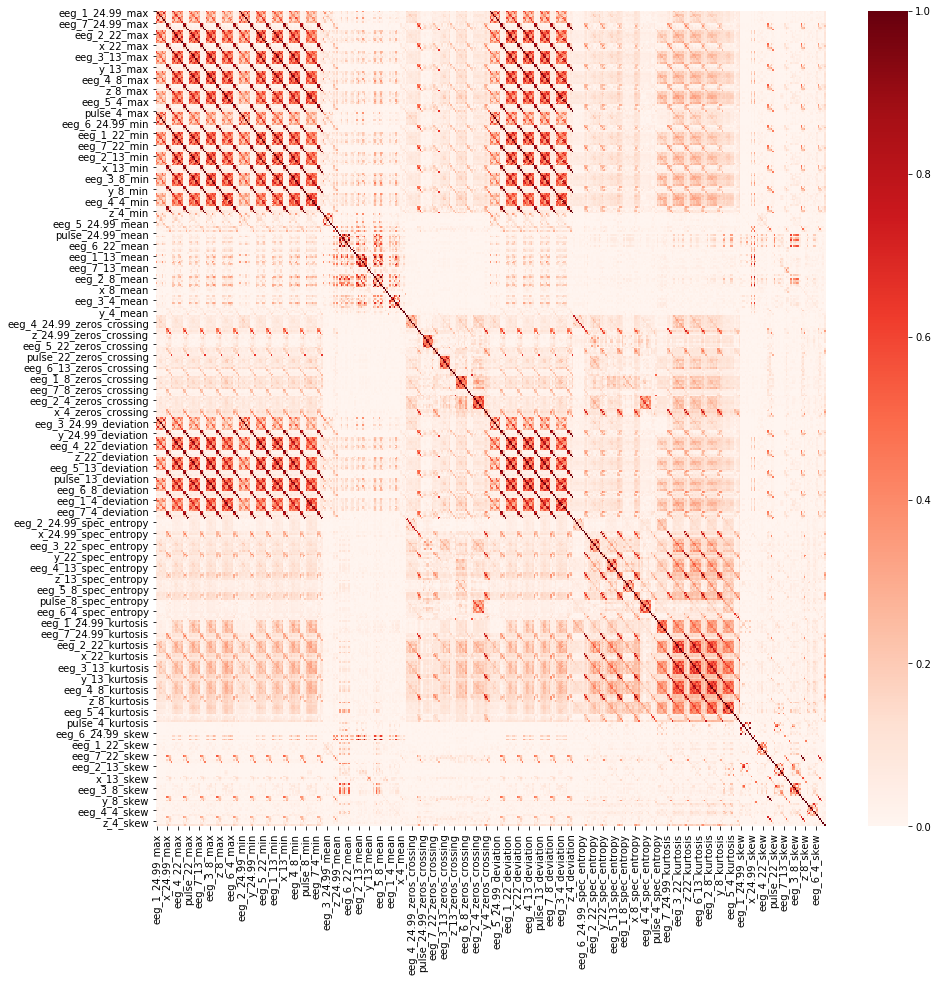

In [10]:
corr_matrix = train_df.corr().abs()
plt.figure(figsize=(15,15))
seaborn.heatmap(corr_matrix, annot=False, cmap=plt.cm.Reds)
plt.show()

Pour rendre cela plus lisible on peut tenter de regarder quels sont les maximums de corrélations entre les différentes features.

In [11]:
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))
print(sol.iloc[0:25])

eeg_2_24.99_max  eeg_2_24.99_min      0.999983
eeg_7_24.99_max  eeg_7_24.99_min      0.999979
eeg_5_24.99_max  eeg_5_24.99_min      0.999978
eeg_1_24.99_max  eeg_1_24.99_min      0.999977
eeg_3_24.99_max  eeg_3_24.99_min      0.999975
eeg_4_24.99_max  eeg_4_24.99_min      0.999966
z_24.99_max      z_24.99_min          0.999966
eeg_6_24.99_max  eeg_6_24.99_min      0.999965
pulse_24.99_max  pulse_24.99_min      0.999945
x_24.99_max      x_24.99_min          0.999807
z_22_max         z_22_min             0.999619
z_24.99_min      z_22_min             0.999528
z_24.99_max      z_22_min             0.999414
                 z_24.99_deviation    0.999360
z_24.99_min      z_24.99_deviation    0.999343
z_13_max         z_13_min             0.999232
z_22_max         z_24.99_min          0.999089
z_22_min         z_24.99_deviation    0.999030
z_24.99_max      z_22_max             0.999018
y_24.99_max      y_24.99_min          0.998942
x_22_max         x_22_min             0.998762
z_22_max     

De manière assez logique les plus fortes corrélations sont issues des liens entre les différents maximums et entre maximums - écart-type.

# Ensemble de test  

Nous allons étudier la répartition des différentes classes dans l'ensemble de test.

In [12]:
keys = [0,1,2,3,4]
class_weight = dict(zip(keys, np.sum(to_categorical(train_df['target'].values),axis=0)/np.sum(to_categorical(train_df['target'].values))))


In [13]:
class_weight

{0: 0.14176928, 1: 0.06810326, 2: 0.38269603, 3: 0.21187082, 4: 0.19556059}

On observe que la classe 1 est sous représentée, par conséquent elle sera probablement plus difficile à prédire avec précision. 

# Random Forest 

La méthode de classification que nous avons décidé d'utiliser est une méthode du type Random Forest. Nous pensons que l'application du prétraitement et que les features nous permettront d'obtenir un score meilleur que le Simple random Forest donné en exemple.


### création du Random Forest

Pour creer le random forest nous allons utiliser la librairie *RandomForestClassifier de *sklearn*. On fixe la profondeur maximale à 50 et on utilise en entrée les class weight dans le but d'améliorer la précision.   
On applique ensuite le random forest à nos données filtrées avec les features réalisés précédemment.

In [14]:
clf = RFC(n_estimators=500, max_depth=50,
                              random_state=0,class_weight=class_weight)
clf.fit(train_df.loc[:, train_df.columns != 'target'].values,train_df['target'])  

RandomForestClassifier(bootstrap=True,
                       class_weight={0: 0.14176928, 1: 0.06810326,
                                     2: 0.38269603, 3: 0.21187082,
                                     4: 0.19556059},
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

### Importance des features    
   
Nous allons maintenant étudier l'importance de chaque feature dans le processus de classification.

In [15]:
importances = clf.feature_importances_
feature_list = train_df.columns.to_list()[0:len(train_df.columns.to_list())-1]
feature_importance = dict(zip(feature_list,importances))
Importance_list = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
Importance_list[0:25]

[('eeg_4_22_zeros_crossing', 0.021085113411240735),
 ('eeg_5_4_deviation', 0.019701105500287797),
 ('eeg_1_4_deviation', 0.016033308864505717),
 ('eeg_3_22_zeros_crossing', 0.01502850731184223),
 ('eeg_6_4_deviation', 0.013341767779706111),
 ('eeg_1_22_zeros_crossing', 0.010709620927576158),
 ('eeg_4_4_deviation', 0.010402882531650653),
 ('eeg_5_4_kurtosis', 0.008934339799862712),
 ('eeg_2_4_deviation', 0.00889792964198346),
 ('eeg_5_22_zeros_crossing', 0.008385945556925095),
 ('eeg_4_13_max', 0.007908480775620015),
 ('eeg_1_4_kurtosis', 0.007814244477733896),
 ('eeg_3_13_min', 0.007744291826334656),
 ('eeg_3_4_deviation', 0.0075801430250944934),
 ('eeg_1_8_deviation', 0.007481904445247863),
 ('eeg_4_8_deviation', 0.007457512941303639),
 ('eeg_4_13_min', 0.007360692610588724),
 ('eeg_5_4_max', 0.0071785440628142),
 ('eeg_3_13_max', 0.007042638088223397),
 ('eeg_5_8_deviation', 0.007006099230600629),
 ('eeg_1_4_max', 0.006810789239935443),
 ('eeg_4_13_deviation', 0.006805014718609393),


On remarque que les zéros crossing et les écarts-types sur les signaux filtrés des électroencéphalogrammes semblent être les variables les plus décisives.

# Résultats


### Calcul du score 

Le score de notre algorithme  est calculé sous la forme d'une moyenne de F1 score. Le F1 score correspond à la valeur : $ 2 \frac{p.r}{p+r} $ ou $p$ représente la précision et $r$ le recall.    
la précision correspond au ratio de vrai positif sur le nombre prédit de positif et le recall correspond au ratio de vrai positif sur le nombre total de positif dans l'échantillon. Un bon algorithme doit assurer une bonne valeur de ces deux indicateurs.   
Ici on calcule le F1 score pour chacune des classes puis on en prends la moyenne pondérée par la fréquence d'apparition de chaque classe. 




### Score sur l'échantillon d'apprentissage

Nous allons maintenant étudier les résultats du Random Forest sur les données de test. 

In [16]:
y_pred = clf.predict(test_df.loc[:, test_df.columns != 'target'].values)
y_true = test_df['target'].values
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
print(y_pred)

              precision    recall  f1-score   support

           0       0.77      0.87      0.82       886
           1       0.64      0.04      0.07       410
           2       0.79      0.89      0.84      2363
           3       0.89      0.82      0.85      1301
           4       0.78      0.81      0.80      1212

    accuracy                           0.80      6172
   macro avg       0.77      0.69      0.68      6172
weighted avg       0.80      0.80      0.78      6172

[2 0 2 ... 2 2 2]


Nous obtenons un F1 score global de l'odre de 0,80.   
Nous pouvons également comparé les class_weight entre les données de test et les prédictions de notre modéle.

In [17]:
class_weight_predicted_val = dict(zip(keys, np.sum(to_categorical(y_pred),axis=0)/np.sum(to_categorical(y_pred))))
print('predict :',class_weight_predicted_val)
class_weight_true_val = dict(zip(keys, np.sum(to_categorical(y_true),axis=0)/np.sum(to_categorical(y_true))))
print('true :',class_weight_true_val)

predict : {0: 0.16121192, 1: 0.004050551, 2: 0.43519118, 3: 0.19475049, 4: 0.20479585}
true : {0: 0.14355153, 1: 0.066429034, 2: 0.38285807, 3: 0.21079066, 4: 0.1963707}


### Score sur l'échantillon de test

Nous pouvons maintenant procéder au test de notre algorithme sur l'échantillon de test.   
Après soumission de notre algorithme nous obtenons un score final de 0,71. Ce score est inférieur à celui obtenu sur l'échantillon de test, cela peut provenir de notre manque de précision sur la classe 1 qui est surement plus représentée dans l'échantillon de test que dans celui d'apprentissage.